In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
from torchvision.models.resnet import ResNet, BasicBlock
import scipy.stats as st
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torchvision import transforms
import torchvision.models as models

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/data")

Mounted at /content/gdrive


In [5]:
# load the labels and split into train and test 
all_densities = pd.read_csv("densities.csv")
test_densities = all_densities[all_densities["Example"].str.contains("Test")]
train_densities = all_densities[all_densities["Example"].str.contains("Train")]

test_densities.to_csv("test_densities.csv", index=False)
train_densities.to_csv("train_densities.csv", index=False)

In [6]:
all_densities.iloc[0][0]

'Mass-Training_P_00076_LEFT_MLO_1.npz'

In [7]:
class Mammogram_Dataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform 
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.load(img_path)['arr_0']
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
          
        image = image.type(torch.float32)
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, label

tensor_transform = transforms.Compose([transforms.ToTensor()])
test_dataset = Mammogram_Dataset("test_densities.csv","numpyz_files",tensor_transform)
train_dataset = Mammogram_Dataset("train_densities.csv","numpyz_files",tensor_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
class modifiedResnet(ResNet):

  def __init__(self, test_dataloader, train_dataloader):
    # to predict two classes 
    super().__init__(BasicBlock, [2, 2, 2, 2], num_classes=2)
    # to accept 1 in depth instead of 3 
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7),stride=(3,3),padding=(3,3), bias=False)

    self.test_dataloader = test_dataloader
    self.train_dataloader = train_dataloader


  def fit(self, num_epoch, verbose=True):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = self
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

    for epoch in range(num_epoch): 
      print("Epoch: "+ str(epoch))
      running_loss = 0.0

      model.train()
      for n, data in enumerate(train_dataloader):
          inputs, labels = data[0].to(device), data[1].to(device)

          
          optimizer.zero_grad() # zero the parameter gradients
          outputs = model(inputs) # forward 
          loss = loss_fn(outputs, labels) # calculate loss 
          loss.backward() # backward 
          optimizer.step() # update parameter

          current_loss = loss.item()
          running_loss += current_loss
          
        # print progress
      if verbose:
        print("Loss: {:.4f}".format(running_loss / (n + 1)))
        print("Finished epoch", epoch)

    print('Finished Training')  

  def predict(self, verbose=True):
    correct = 0
    total = 0
    predictions = [] # class prediction 
    true_labels = []
    probs = [] # probability of each classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)
    model.eval()
    model.to(device)
    progress = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
          
          # send data to device
          images, labels = data[0].to(device), data[1].to(device)

          # perform prediction 
          outputs = model(images)
          # passing through sigmoid layer
          predicted_probs = torch.sigmoid(outputs.data)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(predicted_probs, 1)

          predictions.extend(predicted.cpu().numpy())
          true_labels.extend(labels.cpu().numpy())
          probs.extend(predicted_probs.cpu().numpy())

          # keeping track of number of correct predictions
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # print progress
          if verbose:
            progress += len(labels)
            print("Finished with:", progress, "predictions.")

    print('Accuracy: %d %%' % (100 * correct / total))
    
    return predictions, probs, true_labels
  
class EvaluateClassifier():

  def __init__(self):
    return
    
    
  def confusion_matrix(self, y_pred, y_true):
    cm = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(cm, ["True 0", "True 1"], ["Predicted 0", "Predicted 1"])
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

  def roc_curve(self, y_prob, y_true):
    y_prob = np.array(y_prob)

    # calculate values to draw the roc curve 
    fpr, tpr, _ = roc_curve(y_true, np.array(y_prob)[:,1])
    # calculate the area under the curve value 
    roc_auc = auc(fpr, tpr)

    # plot the roc curve with the auc value 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

  def bootstrap_auc(self, y_pred, y_true, random_state=24, percentile=95):
    seed = 100
    random.seed(seed)
    num_pred = len(y_pred)
    num_bootstrap = 1000 
    bootstrapped_auc = np.array([])
    for i in range(num_bootstrap):
      random_idx = random.choices(range(num_pred), k = num_pred)
      b_y_pred = np.array(y_pred)[random_idx]
      b_y_true = np.array(y_true)[random_idx]
      fpr, tpr, _ = roc_curve(b_y_true, b_y_pred)
      roc_auc = auc(fpr, tpr)

      bootstrapped_auc = np.append(bootstrapped_auc, roc_auc)
    plt.title("Histogram of bootstrapped AUC values")    
    plt.hist(bootstrapped_auc, bins=50);


    lower_bound = np.percentile(bootstrapped_auc, (100 - percentile) / 2)
    upper_bound = np.percentile(bootstrapped_auc, (100 - percentile) / 2 + percentile)

    return lower_bound, upper_bound

  def z_score(self, var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

  def auc(self, X, Y):
    return 1/(len(X)*len(Y)) * sum([self.kernel(x, y) for x in X for y in Y])

  def kernel(self, X, Y):
    return .5 if Y==X else int(Y < X)


  def structural_components(self, X, Y):
    V10 = [1/len(Y) * sum([self.kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([self.kernel(x, y) for x in X]) for y in Y]
    return V10, V01
      
  def get_S_entry(self, V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

  def group_preds_by_label(self, preds, actual):
  
    X = [p for (p, a) in zip(preds, actual) if a] # prediction with actual label = 1
    Y = [p for (p, a) in zip(preds, actual) if not a] # prediction with actual label = 0
    return X, Y
  
  def DeLongTest(self, y_probs, y_true):
    preds_A = np.array(y_probs)[:,1]
    actual = y_true
    preds_B = np.random.rand(preds_A.shape[0]) # predictions from a random classifier
    X_A, Y_A = self.group_preds_by_label(preds_A, actual) # model A
    X_B, Y_B = self.group_preds_by_label(preds_B, actual) # model B

    V_A10, V_A01 = self.structural_components(X_A, Y_A) 
    V_B10, V_B01 = self.structural_components(X_B, Y_B) 
    auc_A = self.auc(X_A, Y_A)
    auc_B = self.auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (self.get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + self.get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (self.get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + self.get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (self.get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + self.get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
    # Two tailed test
    z = self.z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    return p


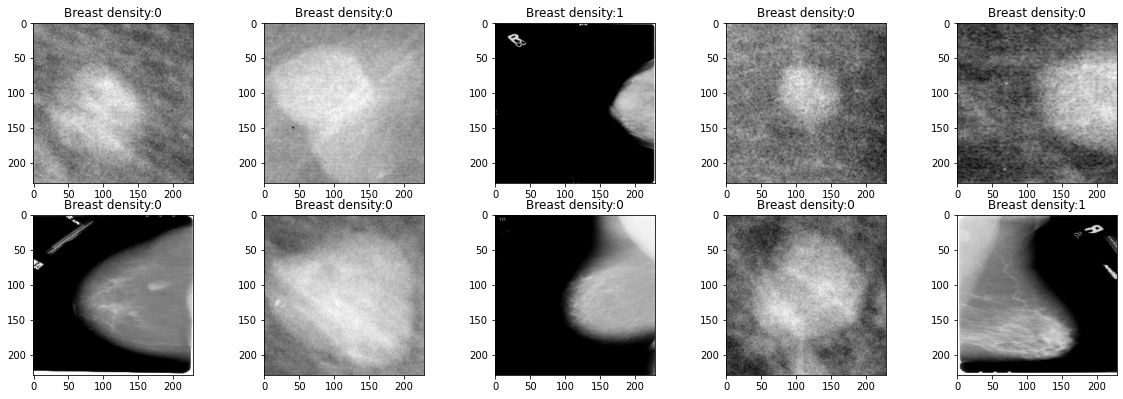

In [12]:
test_iter =  iter(test_dataloader)
features, labels = next(test_iter)

# define figure with 2 rows and 5 columns 
fig = plt.figure(figsize=(20, 10))
rows = 3
columns = 5

num_img = 10
for idx in range(num_img):
  img = features[idx].squeeze()
  label = labels[idx].item()
  fig.add_subplot(rows, columns, idx + 1)
  # display image as grayscale 
  plt.imshow(img, cmap="gray")
  plt.title("Breast density:" + str(label))

In [13]:
model = modifiedResnet(test_dataloader=test_dataloader, train_dataloader=train_dataloader)
model.fit(num_epoch=50, verbose=False)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Finished Training


In [ ]:
y_pred, y_prob, y_true = model.predict()

device:  cuda:0
Finished with: 20 predictions.
Accuracy: 60 %


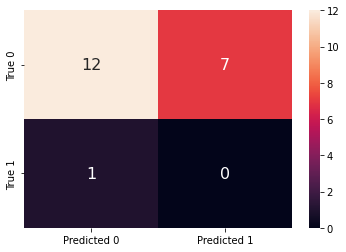

In [ ]:
eval = EvaluateClassifier()
eval.confusion_matrix(y_pred, y_true) # confusion matrix

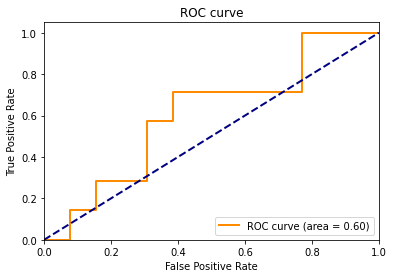

In [ ]:
eval.roc_curve(y_prob, y_true) # roc curve

(0.375, 0.5)


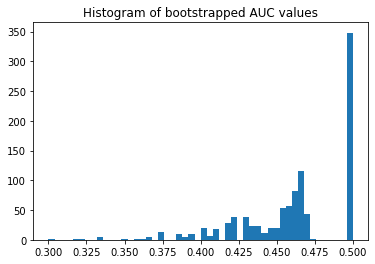

In [ ]:
ci = eval.bootstrap_auc(y_pred, y_true) # histogram of bootstrapped auc
print(ci) # lower and upperbound of confidence interval

In [ ]:
p_val = eval.DeLongTest(y_probs=y_prob, y_true=y_true) 
# perform DeLongTest to compare performance of model to random classifier
p_val # show p-value of DeLongTest, cut-off at 5%

0.3762870032701887